In [1]:
!pip install scanpy
!pip install KDEpy
!pip install leidenalg
!pip install venn

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
  Preparing metadata (setup.py) ... done
  Created wheel for venn: filename=venn-0.1.3-py3-none-any.whl size=19700 sha256=b0b567473b4ce11ae679cc1e3853bd98bc4520c841d670c47eeab79bf05d1e57
  Stored in directory: /tmp/pip-ephem-wheel-cache-gu4rf_2g/wheels/9c/ce/43/705b4a04cd822891d1d7a4c43fc444b4798978e72c79528c5f
Successfully built venn


# Comparing E.coli data in BacDrop vs. ProBac

In [2]:
import pandas as pd
import scanpy as sc
import anndata as ad
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse as sps
from scipy.stats import ranksums, spearmanr, kendalltau

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import tools.util_probe as up
import tools.util as ut
import tools.NB_est as nb
import tools.countsplit as cs
import tools.ClusterDE as cd

import importlib

## Read datasets

In [36]:
data_probac = sc.read_h5ad("../data/MOBA_scRNAseq/outs_S1/filtered_data_maxpool_processed.h5ad")
data_bacdrop = sc.read_h5ad("../data/BacDrop/ecoli_data_processed.h5ad")

In [37]:
data_probac.var

,feature_types,genome,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,n_cells,var_counts,...,nb_umi,Intercept_step1_sct,log_umi_step1_sct,dispersion_step1_sct,mean,std,Locus tag,Protein accession,Name,Symbol
index,,,,,,,,,,,,,,,,,,,,,
aaeA,Gene Expression,PA01,9,0.002953,0.002949,99.734200,10.0,2.397895,9,0.003535,...,1.920116,NaN,NaN,NaN,-5.832159,0.298786,b3241,NP_417708.1,aromatic carboxylic acid efflux pump membrane ...,aaeA
aaeB,Gene Expression,PA01,2,0.000591,0.000590,99.940933,2.0,1.098612,2,0.000590,...,0.853322,NaN,NaN,NaN,-4.744446,0.118880,b3240,NP_417707.1,aromatic carboxylic acid efflux pump subunit AaeB,aaeB
aaeR,Gene Expression,PA01,31,0.010041,0.009991,99.084465,34.0,3.555348,31,0.011713,...,2.427903,NaN,NaN,NaN,-4.477485,0.422165,b3243,NP_417710.1,DNA-binding transcriptional activator AaeR,aaeR
aaeX,Gene Expression,PA01,7,0.002363,0.002360,99.793266,8.0,2.197225,7,0.002948,...,2.829958,NaN,NaN,NaN,-5.979570,0.261760,b3242,NP_417709.2,DUF1656 domain-containing protein AaeX,aaeX
aas,Gene Expression,PA01,63,0.020969,0.020752,98.139398,71.0,4.276666,63,0.025254,...,2.552504,-7.019165,1.389573,0.061361,-3.722110,0.509169,b2836,NP_417313.1,fused 2-acylglycerophospho-ethanolamine acyltr...,aas
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zraR,Gene Expression,PA01,27,0.008565,0.008528,99.202599,29.0,3.401197,27,0.009673,...,2.703250,NaN,NaN,NaN,-4.489861,0.393549,b4004,NP_418432.1,DNA-binding transcriptional activator ZraR,zraR
zraS,Gene Expression,PA01,13,0.003839,0.003832,99.616066,13.0,2.639057,13,0.003825,...,2.436859,NaN,NaN,NaN,-5.603223,0.343977,b4003,NP_418431.1,sensor histidine kinase ZraS,zraS
zupT,Gene Expression,PA01,42,0.014471,0.014368,98.759598,49.0,3.912023,42,0.018397,...,3.061639,NaN,NaN,NaN,-4.000824,0.435151,b3040,NP_417512.1,divalent metal ion transporter ZupT,zupT


In [38]:
data_bacdrop.var

,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,n_cells,var_counts,is_scd_outlier,nb_overdisp,...,highly_variable,highly_variable_rank,means,variances,variances_norm,lt,locus_tag,product_accession,name,symbol
cds-ECs_1431,3,0.003052,0.003047,99.694812,3.0,1.386294,3,0.003043,False,0.178894,...,True,606.0,0.003052,0.003046,0.986901,ECs_1431,NaN,NaN,NaN,NaN
cds-ECs_2321,2,0.002035,0.002033,99.796541,2.0,1.098612,2,0.002030,False,0.119318,...,True,332.0,0.002035,0.002033,0.990919,ECs_2321,NaN,NaN,NaN,NaN
cds-ECs_2323,34,0.034588,0.034003,96.541200,34.0,3.555348,34,0.033393,False,1.412985,...,True,1272.0,0.034588,0.033426,0.829325,ECs_2323,NaN,NaN,NaN,NaN
cds-ECs_2640,3,0.004069,0.004061,99.694812,4.0,1.609438,3,0.006087,False,0.012463,...,True,19.0,0.004069,0.006093,1.473540,ECs_2640,NaN,NaN,NaN,NaN
cds-ECs_2775,3,0.003052,0.003047,99.694812,3.0,1.386294,3,0.003043,False,0.178894,...,True,686.0,0.003052,0.003046,0.986901,ECs_2775,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cds-NP_313381.1,10,0.011190,0.011128,98.982706,11.0,2.484907,10,0.013099,False,0.238012,...,True,140.0,0.011190,0.013113,1.107611,NP_313381.1,ECs_5354,NP_313381.1,transcriptional regulator,rob
cds-NP_313386.1,2,0.002035,0.002033,99.796541,2.0,1.098612,2,0.002030,False,0.119318,...,True,334.0,0.002035,0.002033,0.990919,NP_313386.1,ECs_5359,NP_313386.1,two-component regulatory system response regul...,arcA
cds-YP_009502594.1,17,0.017294,0.017146,98.270600,17.0,2.890372,17,0.016995,False,0.198068,...,True,1196.0,0.017294,0.017012,0.902795,YP_009502594.1,ECs_5391,YP_009502594.1,cytochrome d (bd-I) ubiquinol oxidase subunit X,cydX
cds-YP_009502638.1,2,0.002035,0.002033,99.796541,2.0,1.098612,2,0.002030,False,0.119318,...,True,321.0,0.002035,0.002033,0.990919,YP_009502638.1,ECs_5464,YP_009502638.1,hypothetical protein,yecJ


In [39]:
top_genes_probac = data_probac.var.sort_values("total_counts", ascending=False).iloc[:200, :]
top_genes_bacdrop = data_bacdrop.var.sort_values("total_counts", ascending=False).iloc[:200, :]

In [40]:
top_genes_probac.index


Index(['rpsE', 'rplO', 'rplE', 'rplN', 'rplV', 'rplX', 'rplD', 'rplF', 'fusA',
       'metE',
       ...
       'iscA', 'sdhD', 'spoT', 'rnpA', 'sucC', 'rplY', 'surA', 'glgA', 'glgC',
       'nuoN'],
      dtype='object', name='index', length=200)

In [41]:
top_genes_bacdrop["symbol"]

cds-NP_312192.1    secY
cds-NP_312218.1    fusA
cds-NP_312199.1    rpsN
cds-NP_312217.1    tufB
cds-NP_312938.1    rpoC
                   ... 
cds-NP_312100.1    mlaE
cds-NP_312933.1    rplK
cds-NP_309454.3    opgH
cds-NP_310568.1    proQ
cds-NP_309690.1    ompT
Name: symbol, Length: 200, dtype: category
Categories (1234, object): ['aaeR', 'aas', 'aat', 'abrB', ..., 'znuA', 'znuC', 'zur', 'zwf']

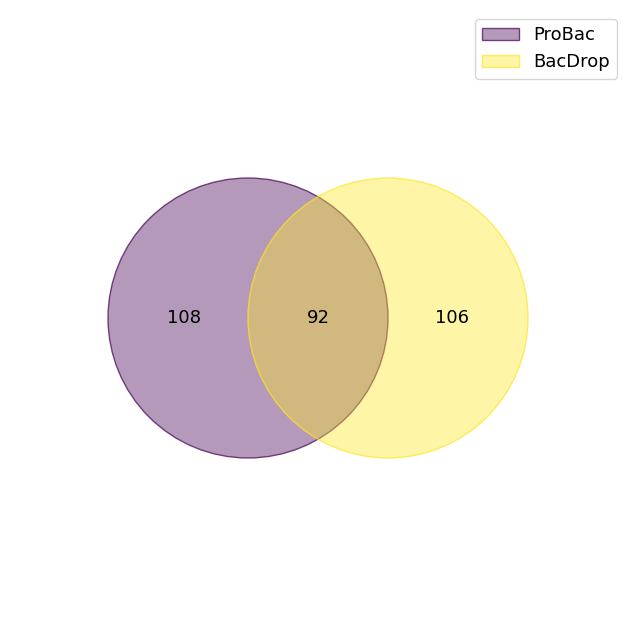

In [42]:
import venn

res_dict = {
    "ProBac": set(top_genes_probac.index.tolist()),
    "BacDrop": set(top_genes_bacdrop["symbol"].tolist()),

}
venn.venn(res_dict)
plt.show()

In [43]:
ranks_probac = pd.DataFrame({
    "rank_probac": np.arange(data_probac.shape[1])}, 
    index=data_probac.var.sort_values("total_counts", ascending=False).index.tolist()
)
bacdrop_high_ex = data_bacdrop.var[data_bacdrop.var["total_counts"] >= 20]
ranks_bacdrop = pd.DataFrame({
    "rank_bacdrop": np.arange(len(bacdrop_high_ex))}, 
    bacdrop_high_ex.sort_values("total_counts", ascending=False)["symbol"].tolist()
)

ranks_bacdrop

,rank_bacdrop
secY,0
fusA,1
rpsN,2
tufB,3
rpoC,4
...,...
prfB,237
fdoG,238
ftsA,239
fabD,240


In [44]:
rank_compare = pd.merge(ranks_probac, ranks_bacdrop, left_index=True, right_index=True, how="outer")
rank_compare = rank_compare[(rank_compare.index.notnull()) & (~rank_compare.index.duplicated(keep='first'))]
rank_compare

,rank_probac,rank_bacdrop
aaeA,2915.0,NaN
aaeB,3852.0,NaN
aaeR,1892.0,NaN
aaeX,3150.0,NaN
aas,1305.0,NaN
...,...,...
zraR,2040.0,NaN
zraS,2709.0,NaN
zupT,1565.0,NaN
zur,1921.0,NaN


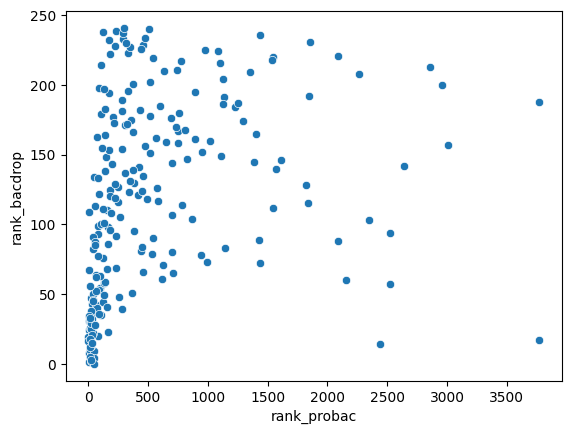

SignificanceResult(statistic=0.4042341220423412, pvalue=4.55366312132519e-19)

In [51]:
sns.scatterplot(rank_compare, x="rank_probac", y="rank_bacdrop")
plt.show()

kendalltau(rank_compare["rank_probac"], rank_compare["rank_bacdrop"], nan_policy="omit")

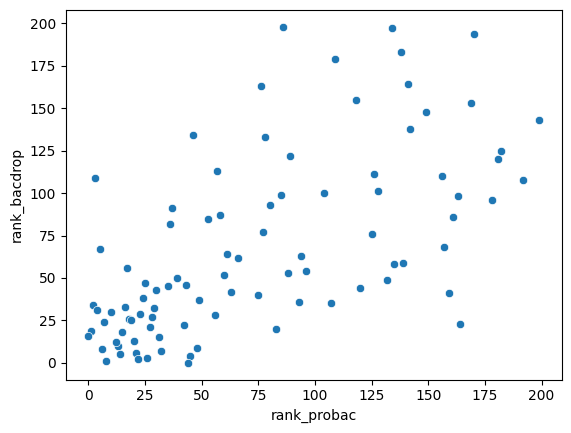

SignificanceResult(statistic=0.46822742474916385, pvalue=3.825320068097652e-11)

In [52]:
sns.scatterplot(rank_compare[(rank_compare["rank_probac"] < 200) & (rank_compare["rank_bacdrop"] < 200)], x="rank_probac", y="rank_bacdrop")
plt.show()

kendalltau(rank_compare[(rank_compare["rank_probac"] < 200) & (rank_compare["rank_bacdrop"] < 200)]["rank_probac"],
           rank_compare[(rank_compare["rank_probac"] < 200) & (rank_compare["rank_bacdrop"] < 200)]["rank_bacdrop"],
           nan_policy="omit")

In [47]:
from scipy.stats import kendalltau

kendalltau(rank_compare["rank_probac"], rank_compare["rank_bacdrop"], nan_policy="omit")

SignificanceResult(statistic=0.4042341220423412, pvalue=4.55366312132519e-19)

In [48]:
discr_1 = rank_compare[(rank_compare["rank_bacdrop"] < 200) & (rank_compare["rank_probac"] > 500)].sort_values("rank_bacdrop")
discr_1

,rank_probac,rank_bacdrop
tdcE,2440.0,14.0
cadA,3772.0,17.0
oppF,2524.0,57.0
frdA,2158.0,60.0
gcvP,617.0,61.0
deaD,711.0,65.0
pta,627.0,71.0
aspA,1438.0,72.0
gpsA,994.0,73.0
fruA,943.0,78.0


In [49]:
data_probac.var.loc[discr_1.index]

,feature_types,genome,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,n_cells,var_counts,...,nb_umi,Intercept_step1_sct,log_umi_step1_sct,dispersion_step1_sct,mean,std,Locus tag,Protein accession,Name,Symbol
tdcE,Gene Expression,PA01,15,0.005316,0.005302,99.556999,18.0,2.944439,15,0.007060,...,2.977437,NaN,NaN,NaN,-5.228769,0.338558,b3114,YP_026205.1,2-ketobutyrate formate-lyase/pyruvate formate-...,tdcE
cadA,Gene Expression,PA01,3,0.000886,0.000886,99.911400,3.0,1.386294,3,0.000885,...,1.176667,-4.254145,-1.237430,0.006059,-4.479315,0.132490,b4131,NP_418555.1,lysine decarboxylase 1,cadA
oppF,Gene Expression,PA01,16,0.004725,0.004714,99.527466,16.0,2.833213,16,0.004703,...,2.647467,NaN,NaN,NaN,-5.486698,0.361603,b1247,NP_415763.1,murein tripeptide ABC transporter/oligopeptide...,oppF
frdA,Gene Expression,PA01,24,0.007383,0.007356,99.291199,25.0,3.258097,24,0.007919,...,2.663947,-9.852968,2.168908,0.020592,-4.857772,0.395368,b4154,NP_418578.1,fumarate reductase flavoprotein subunit,frdA
gcvP,Gene Expression,PA01,164,0.055523,0.054036,95.156527,188.0,5.241747,164,0.066616,...,2.414448,-6.584689,1.625102,0.060117,-2.628792,0.598081,b2903,NP_417379.1,glycine decarboxylase,gcvP
deaD,Gene Expression,PA01,148,0.047253,0.046171,95.629061,160.0,5.081404,148,0.052699,...,2.426173,-8.623356,2.440079,0.026624,-2.791628,0.579368,b3162,NP_417631.2,ATP-dependent RNA helicase DeaD,deaD
pta,Gene Expression,PA01,148,0.054637,0.053196,95.629061,185.0,5.225747,148,0.075869,...,2.510639,NaN,NaN,NaN,-2.690586,0.582450,b2297,NP_416800.1,phosphate acetyltransferase,pta
aspA,Gene Expression,PA01,50,0.017425,0.017275,98.523331,59.0,4.094345,50,0.022437,...,2.480795,-11.849003,3.396842,0.069310,-3.913273,0.465194,b4139,NP_418562.4,aspartate ammonia-lyase,aspA
gpsA,Gene Expression,PA01,91,0.031305,0.030825,97.312463,106.0,4.672829,91,0.039776,...,2.760964,NaN,NaN,NaN,-3.202163,0.525234,b3608,NP_418065.1,glycerol-3-phosphate dehydrogenase,gpsA
fruA,Gene Expression,PA01,93,0.033077,0.032542,97.253396,112.0,4.727388,93,0.043797,...,2.465914,NaN,NaN,NaN,-3.217390,0.536318,b2167,NP_416672.1,fructose-specific PTS multiphosphoryl transfer...,fruA


In [57]:
top_genes_probac = data_probac.var.sort_values("total_counts", ascending=False).iloc[:200, :][[
    "n_cells_by_counts", "mean_counts", "total_counts", "pct_dropout_by_counts"
]]
top_genes_bacdrop = data_bacdrop.var.sort_values("total_counts", ascending=False).iloc[:200, :][[
    "n_cells_by_counts", "mean_counts", "total_counts", "pct_dropout_by_counts", "locus_tag", "name", "symbol"
]]
top_genes_bacdrop

,n_cells_by_counts,mean_counts,total_counts,pct_dropout_by_counts,locus_tag,name,symbol
cds-NP_312192.1,568,1.179044,1159.0,42.217701,ECs_4165,preprotein translocase membrane subunit SecY,secY
cds-NP_312218.1,475,0.933876,918.0,51.678535,ECs_4191,protein chain elongation factor EF-G,fusA
cds-NP_312199.1,375,0.760936,748.0,61.851475,ECs_4172,30S ribosomal subunit protein S14,rpsN
cds-NP_312217.1,448,0.713123,701.0,54.425229,ECs_4190,translation elongation factor EF-Tu 1,tufB
cds-NP_312938.1,391,0.631740,621.0,60.223805,ECs_4911,RNA polymerase beta prime subunit,rpoC
...,...,...,...,...,...,...,...
cds-NP_312100.1,23,0.025432,25.0,97.660224,ECs_4073,ABC transporter permease,mlaE
cds-NP_312933.1,23,0.024415,24.0,97.660224,ECs_4906,50S ribosomal subunit protein L11,rplK
cds-NP_309454.3,21,0.024415,24.0,97.863683,ECs_1427,membrane glycosyltransferase,opgH
cds-NP_310568.1,23,0.024415,24.0,97.660224,ECs_2541,ProP effector,proQ


In [75]:
top_genes = pd.merge(top_genes_probac, top_genes_bacdrop, left_index=True, right_on="symbol", how="inner", suffixes=("_probac", "_bacdrop"))
top_genes.index = top_genes["symbol"]
top_genes = top_genes[~top_genes.index.duplicated(keep='first')]
top_genes

,n_cells_by_counts_probac,mean_counts_probac,total_counts_probac,pct_dropout_by_counts_probac,n_cells_by_counts_bacdrop,mean_counts_bacdrop,total_counts_bacdrop,pct_dropout_by_counts_bacdrop,locus_tag,name,symbol
symbol,,,,,,,,,,,
rpsE,3011,1.930597,6537.0,11.075015,262,0.363174,357.0,73.346897,ECs_4168,30S ribosomal subunit protein S5,rpsE
rplO,3010,1.911991,6474.0,11.104548,189,0.293998,289.0,80.773143,ECs_4166,50S ribosomal subunit protein L15,rplO
rplE,3064,1.871234,6336.0,9.509746,120,0.170905,168.0,87.792472,ECs_4173,50S ribosomal subunit protein L5,rplE
rplN,2983,1.710573,5792.0,11.901949,37,0.041709,41.0,96.236012,ECs_4175,50S ribosomal subunit protein L14,rplN
rplV,2838,1.572947,5326.0,16.184288,152,0.192269,189.0,84.537131,ECs_4180,50S ribosomal subunit protein L22,rplV
...,...,...,...,...,...,...,...,...,...,...,...
rpoD,616,0.217366,736.0,81.807442,46,0.050865,50.0,95.320448,ECs_3950,RNA polymerase sigma 70 factor RpoD,rpoD
lpxD,594,0.214117,725.0,82.457177,37,0.038657,38.0,96.236012,ECs_0181,UDP-3-O-(3-hydroxymyristoyl)-glucosamine N-acy...,lpxD
lpd,606,0.213822,724.0,82.102776,34,0.036623,36.0,96.541200,ECs_0120,dihydrolipoyl dehydrogenase,lpd


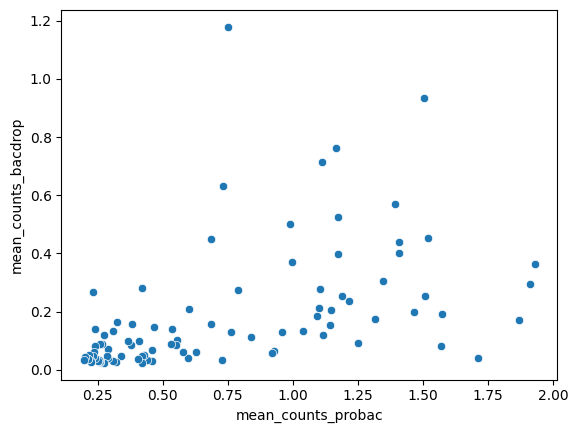

,mean_counts_probac,mean_counts_bacdrop
mean_counts_probac,1.000000,0.667594
mean_counts_bacdrop,0.667594,1.000000


In [76]:
sns.scatterplot(top_genes, x="mean_counts_probac", y="mean_counts_bacdrop")
plt.show()
top_genes[["mean_counts_probac", "mean_counts_bacdrop"]].corr(method="spearman")